# Anomaly Detection - Zelong
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>

<br>

**Dennis Milechin, Ivan Sunyagin, Hany Bassily**

<br>
## Testing Model for Basic Anomalies


<br>

Import libraries

In [13]:
import numpy as np
import pandas as pd
import scipy as sp
import time
from scipy.integrate import simps

import pydotplus
from IPython import display
from IPython.display import Image
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_palette("RdBu", n_colors=32)
from inspect import getmembers

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors

from scipy import stats
import numpy.fft as FFT
from scipy.stats import gaussian_kde as PDF

import collections
from matplotlib import rcParams
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

**---**

## Open a datasets

<br>

### 1- Function to open datasets

<br>

In [14]:
# Function to open a dataset:
# --------------------------
# dataopen function
# Description: The function opens the file for specific bouy and extracts the data.
# Input:
#       buoy - Bouy ID
#       column_names - List of columns to extract
# Return:
#       dataframe with predicted results.
def dataopen(buoy_ID , column_names):
    
    # Data dictionary
    data_dic = {}

    # specify date columns
    date_range = [[0,1,2,3,4]]
    
    # Create a date parser
    dateparse = lambda x: pd.datetime.strptime(x, '%Y %m %d %H %M')

    # Loop through each file for the bouy_ID and open the file and store the data in a DataFrame.  Store the collection of 
    # dataframes in a List.
    for i in range(9):
        file_name = 'datasets/' + buoy_ID + '/' + buoy_ID + str(i+1) + '2016.txt'
        inter = pd.read_csv(file_name , delim_whitespace = True , skiprows = [1],
                                                  parse_dates = {'DATETIME' : [0,1,2,3,4] },
                                             date_parser=dateparse)
        data_dic['df_' + str(i + 1)] = inter#.iloc[:,1:]
        
    # initiation
    df_global_raw = data_dic['df_1']

    # Concatenate the list of dataframes into one dataframe
    for i in range(1,9):
        df_global_raw = pd.concat([df_global_raw , data_dic['df_' + str(i + 1)]] , axis = 0)
        
    #Include DateTime column in the filtering    
    column_names.append('DATETIME')

    # Extract only columns of interest.
    df_global = df_global_raw[column_names]

    return df_global

### 2- Preliminary Data Evaluation

Load the data for the select bouys and load only data for windspeed and surface pressure.
<br>

In [15]:
# Data for evalaution:
# -------------------

# Buoy 
buoy_s = ['41041' , '41043' , '41046' , '41047']

# data array for windspeed
collection = []

for i in range(len(buoy_s)):
    b = buoy_s[i]
    df = dataopen(b , ['WSPD', 'PRES'])
    collection.append(df)
    
print 'Done!'

Done!


**Create plots for the extracted data.**

**Show Wind Speed Plots**

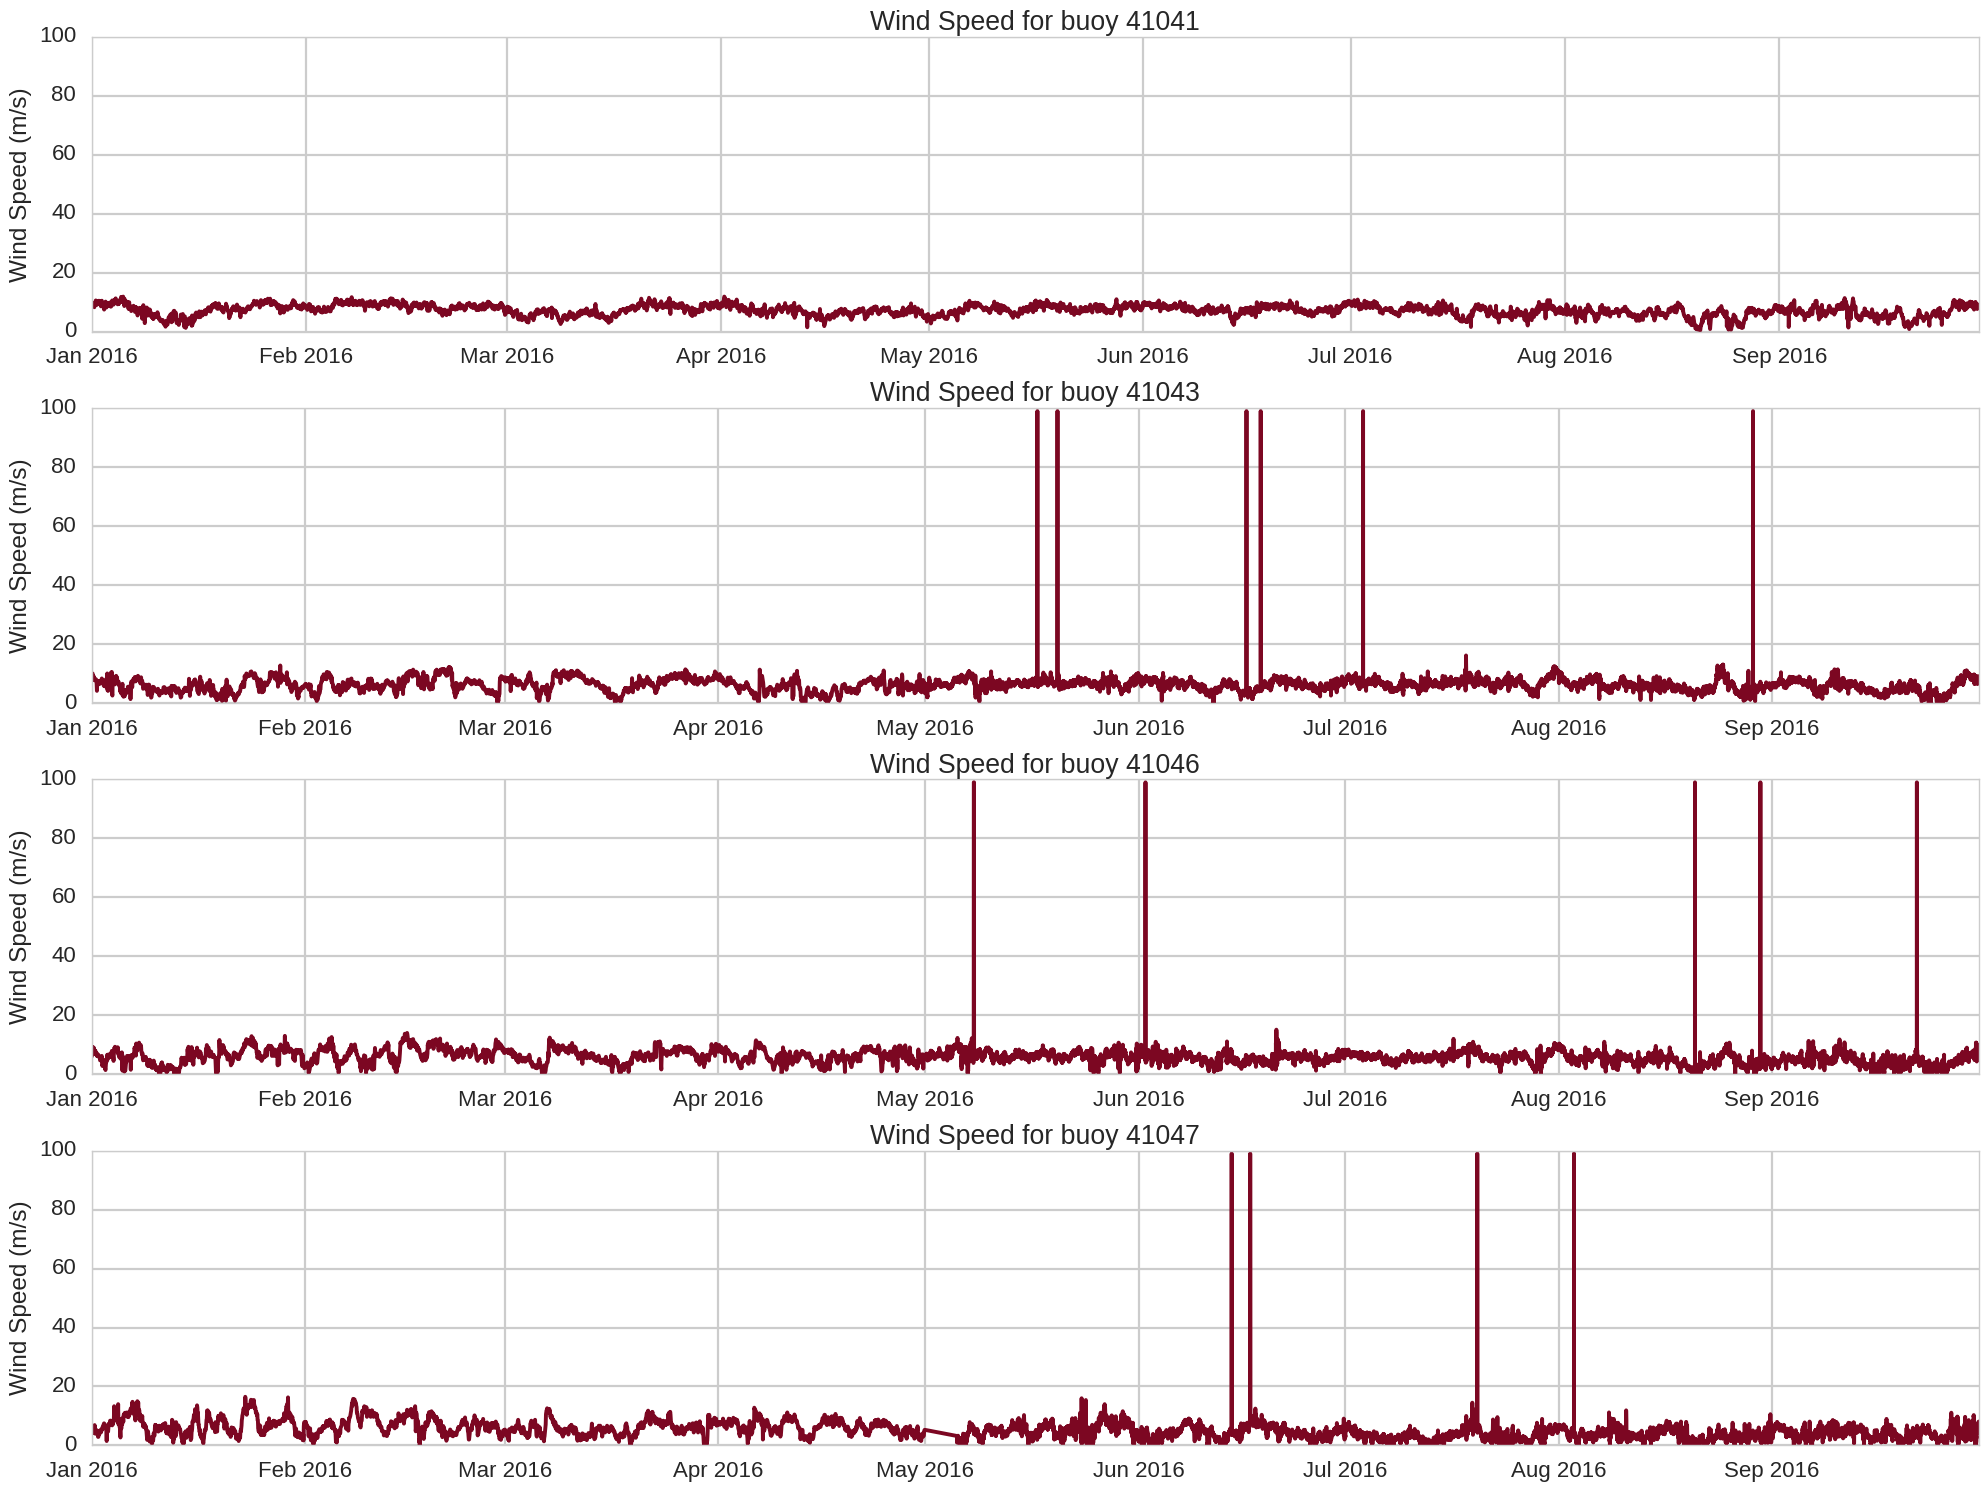

In [16]:
# Visualization of windspeed:
# ---------------------------
fig = plt.figure(figsize = (20,15))

for i in range(4):
    x = collection[i]
    ax = fig.add_subplot(4 , 1 , i + 1)
    ax.plot(x['DATETIME'], x['WSPD'] )
    ax.set_ylim([0, 100])
    ax.set_title('Wind Speed for buoy ' + buoy_s[i])
    ax.set_ylabel('Wind Speed (m/s)')
    
plt.tight_layout()
plt.show()

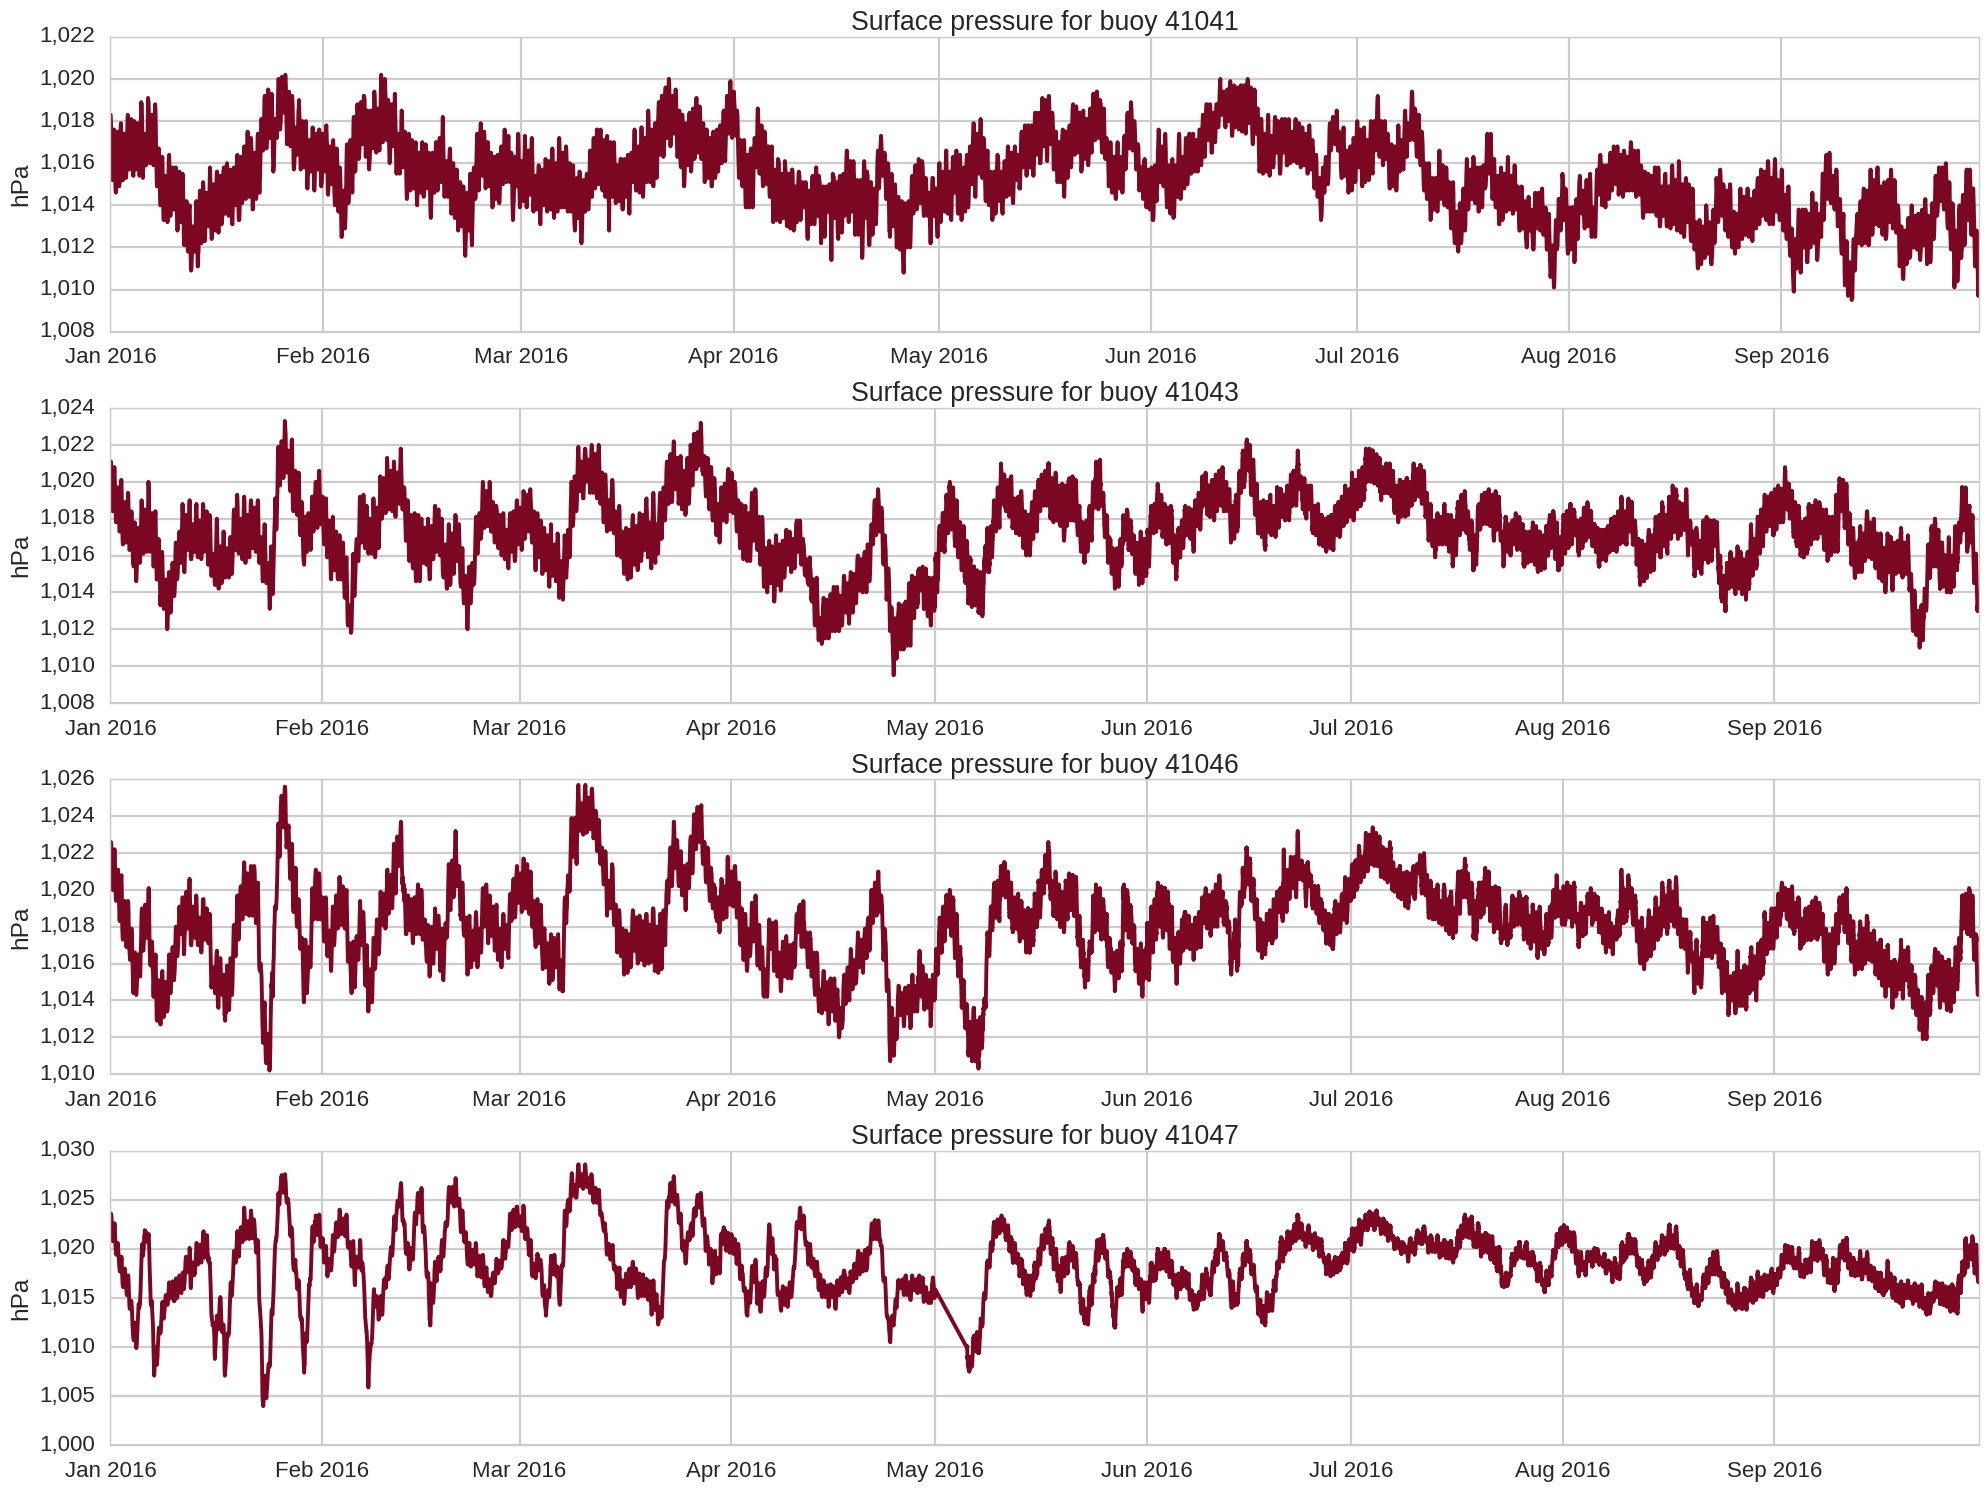

In [36]:
# Visualization of pressure:
# -------------------------
fig = plt.figure(figsize = (20,15))

for i in range(4):
    x = collection[i]
    ax = fig.add_subplot(4 , 1 , i + 1)
    ax.plot(x['DATETIME'], x['PRES'])
    #ax.set_ylim([0 , 25000])
    ax.set_title('Surface pressure for buoy ' + buoy_s[i])
    ax.set_ylabel('hPa')
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
plt.tight_layout()
plt.show()

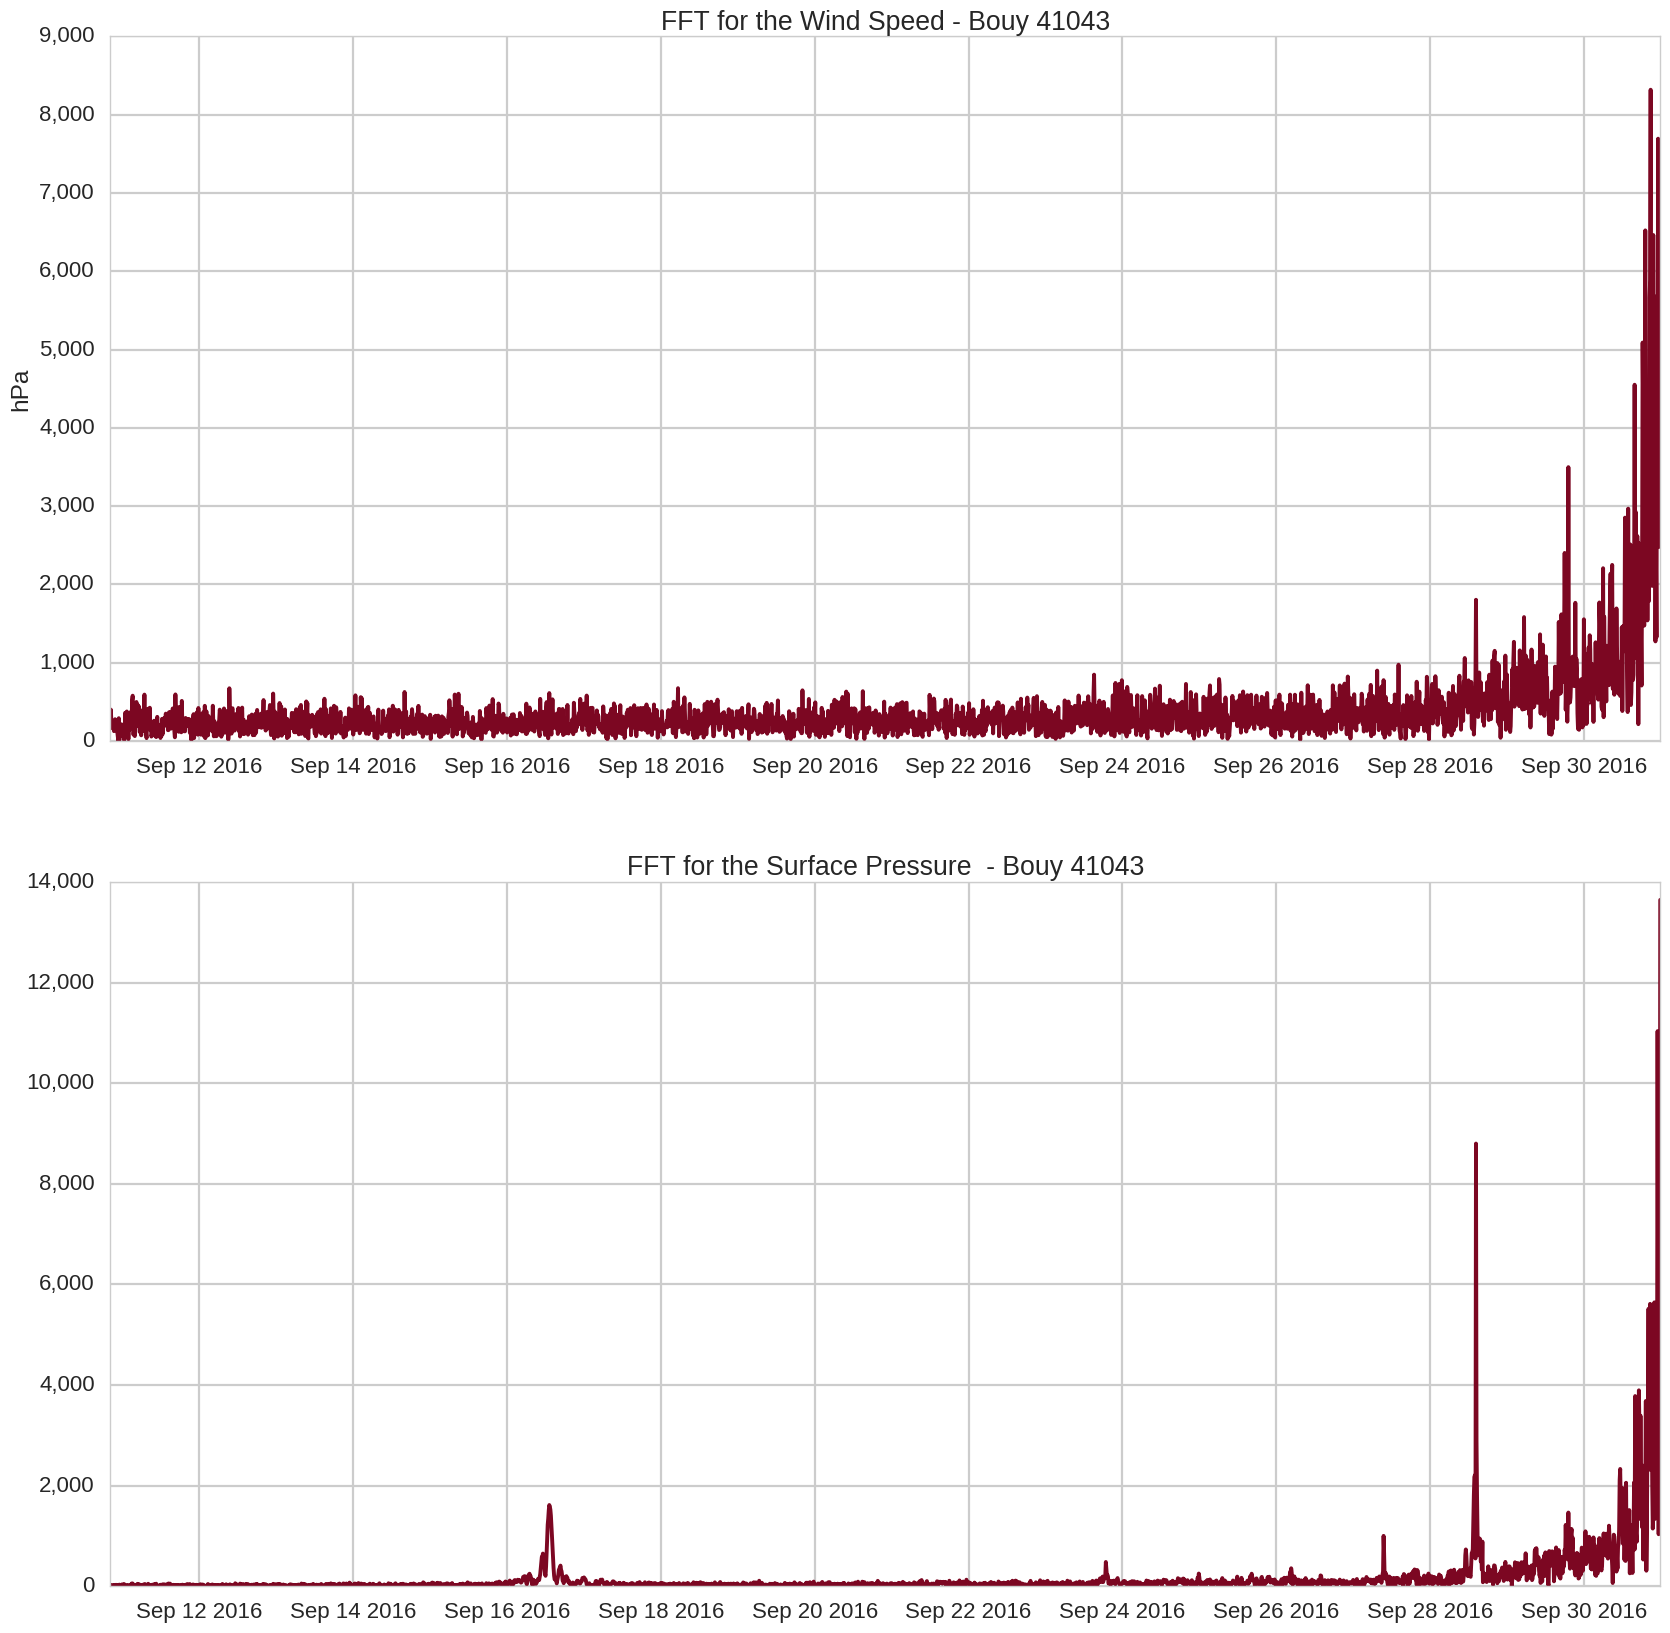

In [19]:
# Fast Fourier Transform
#-----------------------

# Extract Signal
x_all = collection[1].values

Length = x_all.shape[0]

# Calculate FFT for windspeed and pressure
wind_ft = np.absolute(FFT.fft(x_all[:,0]))

pres_ft = np.absolute(FFT.fft(x_all[:,1]))

# Visualization

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(211)
ax1.plot(collection[1]['DATETIME'][22000:], wind_ft[22000:])
ax1.set_title('FFT for the Wind Speed - Bouy 41043')
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
ax1.set_ylabel('m/s')

ax2 = fig.add_subplot(212)
ax2.plot(collection[1]['DATETIME'][22000:], pres_ft[22000:])
ax2.set_title('FFT for the Surface Pressure  - Bouy 41043')
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
ax1.set_ylabel('hPa')

plt.show()

**Discussion:**

<br>
The FFT does not show significant spectral slope which is typical for the climate data. In this case, the focus will be on the outliers and the change floor anomalies. for the outliers the WSPD signal will be considered with data of Buoy 41041 as training and buoy 41043 as test.

For the floor change the training set will be the data for buoy 41041 and the test set will be buoy 41047 as the low frequency content is changing in two section the begining (till index 3000) and a low frequency component between index 10000 and 15000

<br>



## 2.0 Establish Training and Testing data sets.

In [20]:
# Training and test sets
# -----------------------

# Outliers Training
out_train = collection[0]['WSPD'].values

# Outlier Test
out_test = collection[1]['WSPD'].values

# Floor Training
floor_train = collection[0]['PRES'].values

# Floor Test
floor_test = collection[3]['PRES'].values




<br>
The following section we will pre-calculate from the training set a type of stangeness function based on the jump rate of the signal or the absolute delta between two consuctive values.

The average jump rate from the training set will be the reference for the starngeness

<br>

 
## 3.0-  Function to Calculate jump rate Strangeness:

<br>
#### Strangeness Options Flag (to be applied in Maringale computation functions):

  1- Distance<br>
  2- Standard deviation<br>
  3- Jump rate<br>
 
 
 
<br>

In [21]:
# alpha_calc function
# Description: Calculates Alpha Values
# Input:
#       train - numpy matrix containing the training data set
#       test - Lnumpy matrix containing the testing data set
# Return:
#       Alpha Values

def alpha_calc(train , test):
    
    # initiation
    train_d = np.zeros(train.shape)
    test_d = np.zeros(test.shape)
    
    # Calculate refeence jump rate from training
    for i in range(1,train_d.shape[0]):
        train_d[i] = np.absolute(train[i] - train[i-1])
    
    # Calculate test jump rate
    for i in range(1, test_d.shape[0]):
        test_d[i] = np.absolute(test[i] - test[i-1])

    return test_d / np.average(train_d)

## 4.0 General Functions

<br>
For the Martingales calculation three types of strangness function will be considered:
 - Jump rate ratio where the actual jump rate wil be compared to the training jump rate (can work for outliers)
 - standard deviation where the actual value will be compared to the normalized training set distribution
 - Distance function where the actual observation vector will be compared to a reference vector equal to the training set mean vector plus a vector of magnitude of one standard deviation of the training set 

The reason for selecting the mean plus one standard deviation is to make the function work when the data has a zero mean


Below, three Power Martingale functions are defined:

<ol>
<li>Power Martingale with defined Epsilon
<li>Power Martingale with Mixture 
<li>Plugin Martingale 

<ol>


### 1- Power Martingale with defined Epsilon

<br>

In [22]:
# Function to calculate Power Martingale - Single Epsilon:
# -------------------------------------------------------
# power_martingale function
# Description: Calculates Power Martingale for outlier detection
# Input:
#       train - numpy matrix containing the training data set
#       test - numpy matrix containing the testing data set
#       eps - epsilon value
#       alpha_flag - 1,2,3
# Return:
#       datpower_mart - Power Martingale Value
#       diff_arr - Power Martingale Value Difference
#
def power_martingale(train , test , eps , alpha_flag):
 
    # data mean
    mean = np.average(train , axis = 0)
    
    # mean vector norm
    mean_norm = np.linalg.norm(mean)

    # strangenes reference for distance
    ref_alpha = np.linalg.norm(train.std(axis = 0)) + mean_norm

    # Length of data
    L = test.shape[0]
    

    # alpha
    if alpha_flag == 1:
        alpha = np.absolute(test) / ref_alpha
        
    elif alpha_flag == 2:
        alpha = np.absolute(test - np.average(train)) /  train.std(axis=0)
        
    else:
        alpha = alpha_calc(train , test)

    # p-value(randomised)
    p_value = np.ones(alpha.shape)

    # iterrate for p-value calculation
    for i in range(1,L):
    
        # end value
        end = alpha[i]
    
        # alpha subset
        alpha_sub = alpha[:i + 1]

        # number of elements
        n = i + 1   
    
        # p-values calculation
        np.random.seed(200)
        p_value[i] = ( float(np.sum(alpha_sub > end)) + np.random.uniform() * np.sum(alpha_sub == end ) ) / float(n)
    
        # to avoid log zero
        p_value[p_value==0] = 0.0000000001
    
    # initiate Power Martingale
    power_mart = np.zeros(alpha.shape)

    # dummy multiplier
    M = 0.
    
    # initiate difference measure
    diff_arr = np.zeros((L,))

    # iterrate for power martingale calculation
    for i in range(L):
        
        # increment
        delta = eps * (p_value[i]) ** (eps - 1.)
        
        # Calculate martingale difference
        diff_arr[i] = np.absolute(np.log(delta))
        
        # Update power martingal
        M += np.log(delta)  
        
        # Array
        power_mart[i] = M
        
    return power_mart , diff_arr

### 2- Mixture Power Martingale

<br>

In [23]:
# Function to calculate Mix Power Martingale:
# -------------------------------------------
# power_martingale_mix function
# Description: Calculates Power Martingale for outlier detection with mixture
# Input:
#       train - numpy matrix containing the training data set
#       test - numpy matrix containing the testing data set
#       res - Resolution of the uniform distribution for integrating epsilon values.
#       alpha_flag - 1,2,3
# Return:
#       datpower_mart - Power Martingale Value
#       diff_arr - Power Martingale Value Difference
#
def power_martingale_mix(train, test , res, alpha_flag):
    
    # epsilon array
    eps = np.linspace(0.001, 0.999, res)
    
    # data mean
    mean = np.average(train , axis = 0)
    
    # mean vector norm
    mean_norm = np.linalg.norm(mean)

    # strangenes reference for distance
    ref_alpha = np.linalg.norm(train.std(axis = 0)) + mean_norm
    

    # Length of data
    L = test.shape[0]

    # alpha
    if alpha_flag == 1:
        alpha = np.absolute(test) / ref_alpha
        
    elif alpha_flag == 2:
        alpha = np.absolute(test - np.average(train)) /  train.std(axis=0)
        
    else:
        alpha = alpha_calc(train , test)

    # p-value(randomised)
    p_value = np.ones(alpha.shape)

    # iterrate for p-value calculation
    for i in range(1,L):
    
        # end value
        end = alpha[i]
    
        # alpha subset
        alpha_sub = alpha[:i - 1]

        # number of elements
        n = i + 1   
    
        # p-values calculation
        np.random.seed(200)
        p_value[i] = ( float(np.sum(alpha_sub > end)) + np.random.uniform() * np.sum(alpha_sub == end ) ) / float(n)
    
        # to avoid log zero
        p_value[p_value==0] = 0.00000000001
    
    # initiate Power Martingale
    power_mart = np.zeros(alpha.shape)
    
    # initiate difference
    diff_arr = np.zeros(alpha.shape)

    # dummy multiplier
    M = 0.

    # iterrate for power martingale calculation
    for i in range(L):
    
        # Calculate delta Array    
        delta = np.log(eps) + (eps - 1.) * np.log(p_value[i])
        
        # Integrate for mix
        delta_mix = simps(delta , eps)
        
        # update power martingale
        M += delta_mix
        
        # Array
        power_mart[i] = M
        
        # difference
        diff_arr[i] = np.absolute(delta_mix)
        
        
    return power_mart , diff_arr

### 3- Plugin Martingale

<br>

In [24]:
# Function to calculate Plugin Martingale:
# ---------------------------------------
# plugin_martingale_o function
# Description: Calculates Power Martingale for outlier detection with a plugin variation
# Input:
#       train - numpy matrix containing the training data set
#       test - Lnumpy matrix containing the testing data set
#       alpha_flag - 1,2,3
# Return:
#       datpower_mart - Power Martingale Value
#       diff_arr - Power Martingale Value Difference
#
def plugin_martingale(train , test , alpha_flag):
    
    # data mean
    mean = np.average(train , axis = 0)
    
    # mean vector norm
    mean_norm = np.linalg.norm(mean)

    # strangenes reference
    ref_alpha = np.linalg.norm(train.std(axis = 0)) + mean_norm
    # ref_alpha = train.std(axis=0)

    # Length of data
    L = test.shape[0]

    # alpha
    if alpha_flag == 1:
        alpha = np.absolute(test) / ref_alpha
        
    elif alpha_flag == 2:
        alpha = np.absolute(test - np.average(train)) /  train.std(axis=0)
        
    else:
        alpha = alpha_calc(train , test)
    
    # p-value(randomised)
    p_value = np.zeros(alpha.shape)

    # iterrate for p-value calculation
    for i in range(1,L):
    
        # end value
        end = alpha[i]
    
        # alpha subset
        alpha_sub = alpha[:i+1]

        # number of elements
        n = i + 1   
    
        # p-values calculation
        p_value[i] = ( float(np.sum(alpha_sub > end)) + np.random.uniform() * np.sum(alpha_sub == end ) ) / float(n)
    
        # to avoid log zero
        p_value[p_value==0] = 0.00000001
        
    # Extended sample
    p_value_neg = - p_value
    p_value_ref = 2.0 - p_value
    
    # initiate Power Martingale
    power_mart = np.zeros(alpha.shape)
    
    # initiate difference
    diff_arr = np.zeros(alpha.shape)

    # dummy multiplier
    M = 0.

    # iterrate for plugin martingale calculation
    for i in range(1,L):
        
        # samples
        s1 = p_value_neg[:i]
        s2 = p_value[:i]
        s3 = p_value_ref[:i]
        
        # concatenation
        s12 = np.concatenate((s1 , s2) , axis = 0)
        sample = np.concatenate((s12 , s3) , axis  = 0)
       
        
        # Estimate pdf
        den = PDF(sample, bw_method='silverman')
        
        # Integral
        A = den.integrate_box_1d(0,1)
        
        # Evaluate
        f =  den.evaluate(p_value[i]) / A
        delta = np.log(f)
        M += delta
        power_mart[i] = M 
        diff_arr[i] = delta
    
    # First Element
    power_mart[0] = power_mart[1]   
    
    
    return power_mart , diff_arr

### 4- Support Functions

<br>

In [25]:
# Exponential Smoother:
# ---------------------
# smooth function
# Description: Exponential Smoother
# Input:
#       y - Data to be smoothed
#       alpha - alpha parameter
# Return:
#       x - smoothed values
def smooth(y , alpha):
    
    # initiation of the filtered signal array
    x = np.zeros(y.shape)
    
    # Data size
    L = y.shape[0]
    
    # intiation
    x[0] = 0.5 * (1. + alpha) * y[0]
    
    # Iterrate for new samples
    for i in range(1,L):
        x[i] = alpha * y[i] + (1. - alpha) * x[i - 1]
        
    return x



<br>
**Constants for Computation:**

<br>

In [26]:
# Resolution for mixture integral
resolution = 200

# Smoothing factor for change detection
a = 0.008

# Data size
L = out_test[0]

# Color map 
clr = plt.get_cmap('jet')

## 5.0- Outlier detection

<br>

In [27]:
# Application and Visualization(Power Martingale)
# ----------------------------------------------

# Fixed Epsilon 
p_mar1_pwr , diff1_pwr = power_martingale(out_train, out_test , 0.1 , 3)

# Mixed martingale
p_mar2_pwr, diff2_pwr = power_martingale_mix(out_train , out_test , resolution , 3)

# Plugin Martingale
p_mar3_pwr, diff3_pwr = plugin_martingale(out_train , out_test , 3)

##

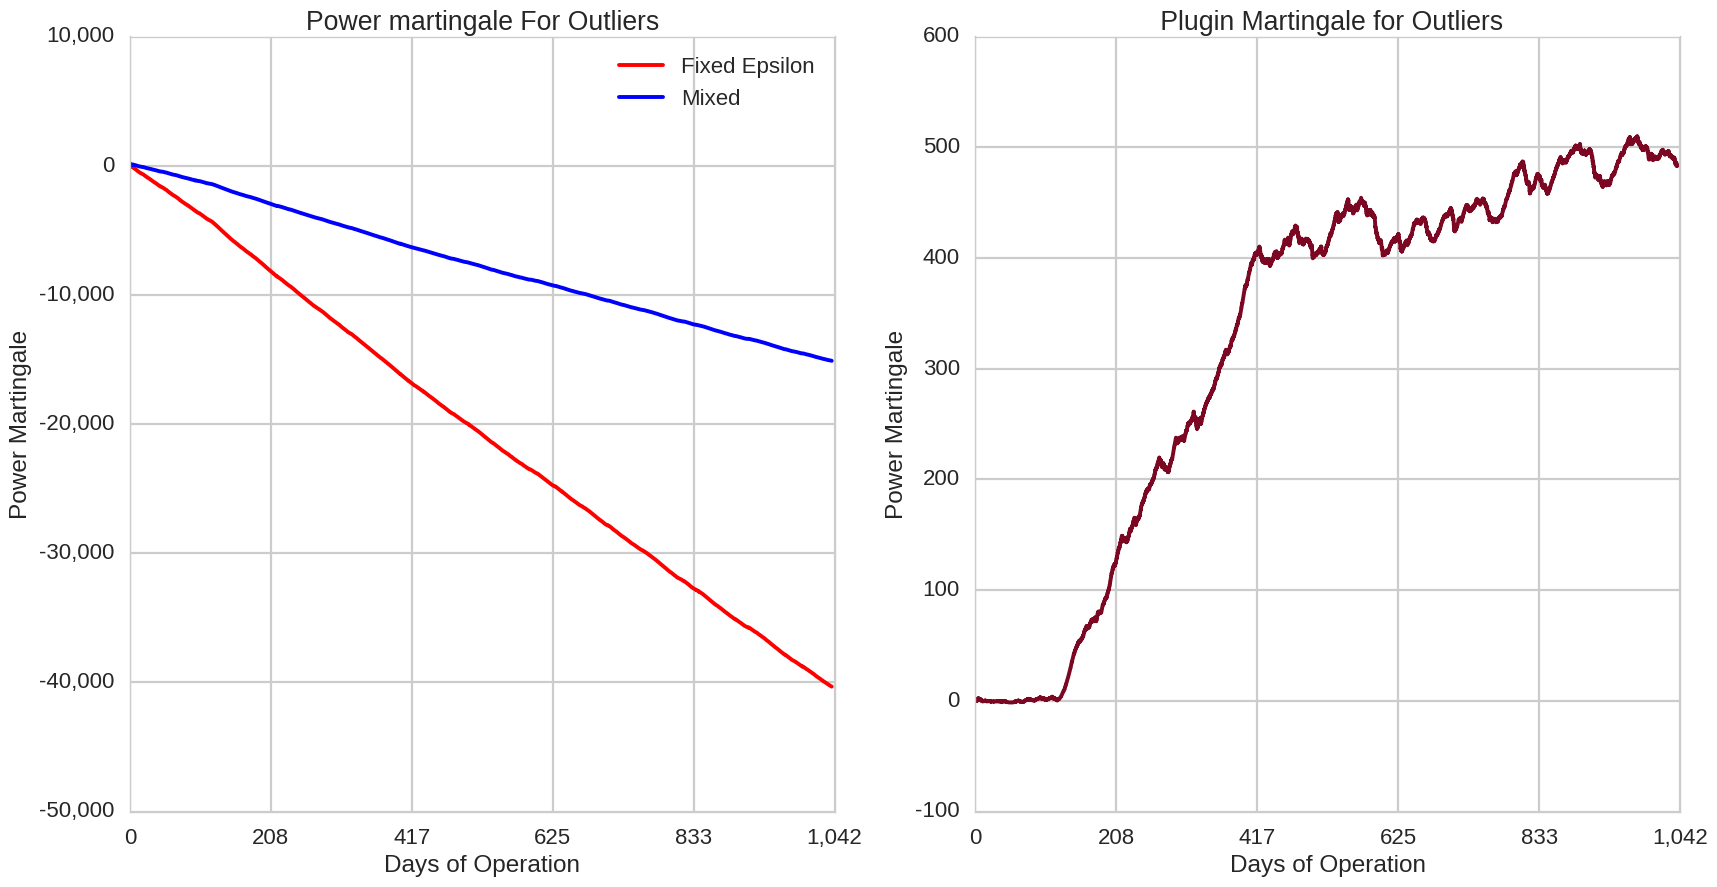

In [31]:
# Visualization of Power Martingale
# ---------------------------------

# plot initialization
fig = plt.figure(figsize = (20,10))

# plot fixed epsilon
ax1 = fig.add_subplot(1,2,1)
ax1.plot(p_mar1_pwr , 'r' , label = 'Fixed Epsilon')
ax1.plot(p_mar2_pwr , 'b' , label = 'Mixed')
ax1.set_title('Power martingale For Outliers')
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')
ax1.set_ylabel('Power Martingale')
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

ax1.legend()

# plot Plugin
ax2 = fig.add_subplot(1,2,2)
ax2.plot(p_mar3_pwr)
ax2.set_title(' Plugin Martingale for Outliers')
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax2.set_xlabel('Days of Operation')
ax2.set_ylabel('Power Martingale')
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

plt.show()


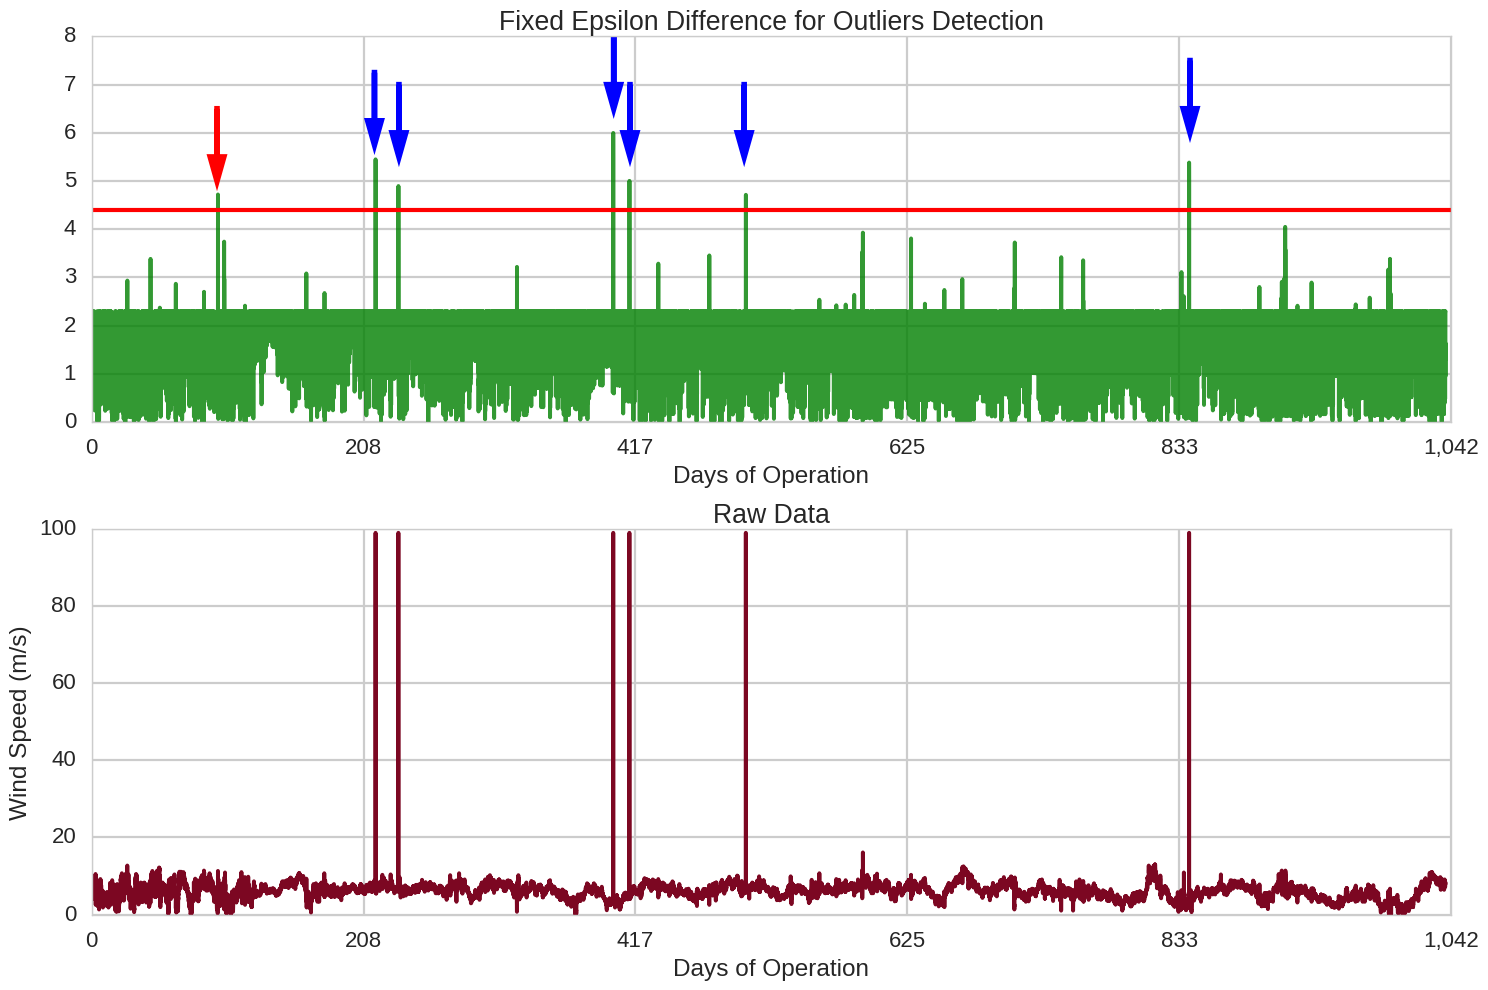

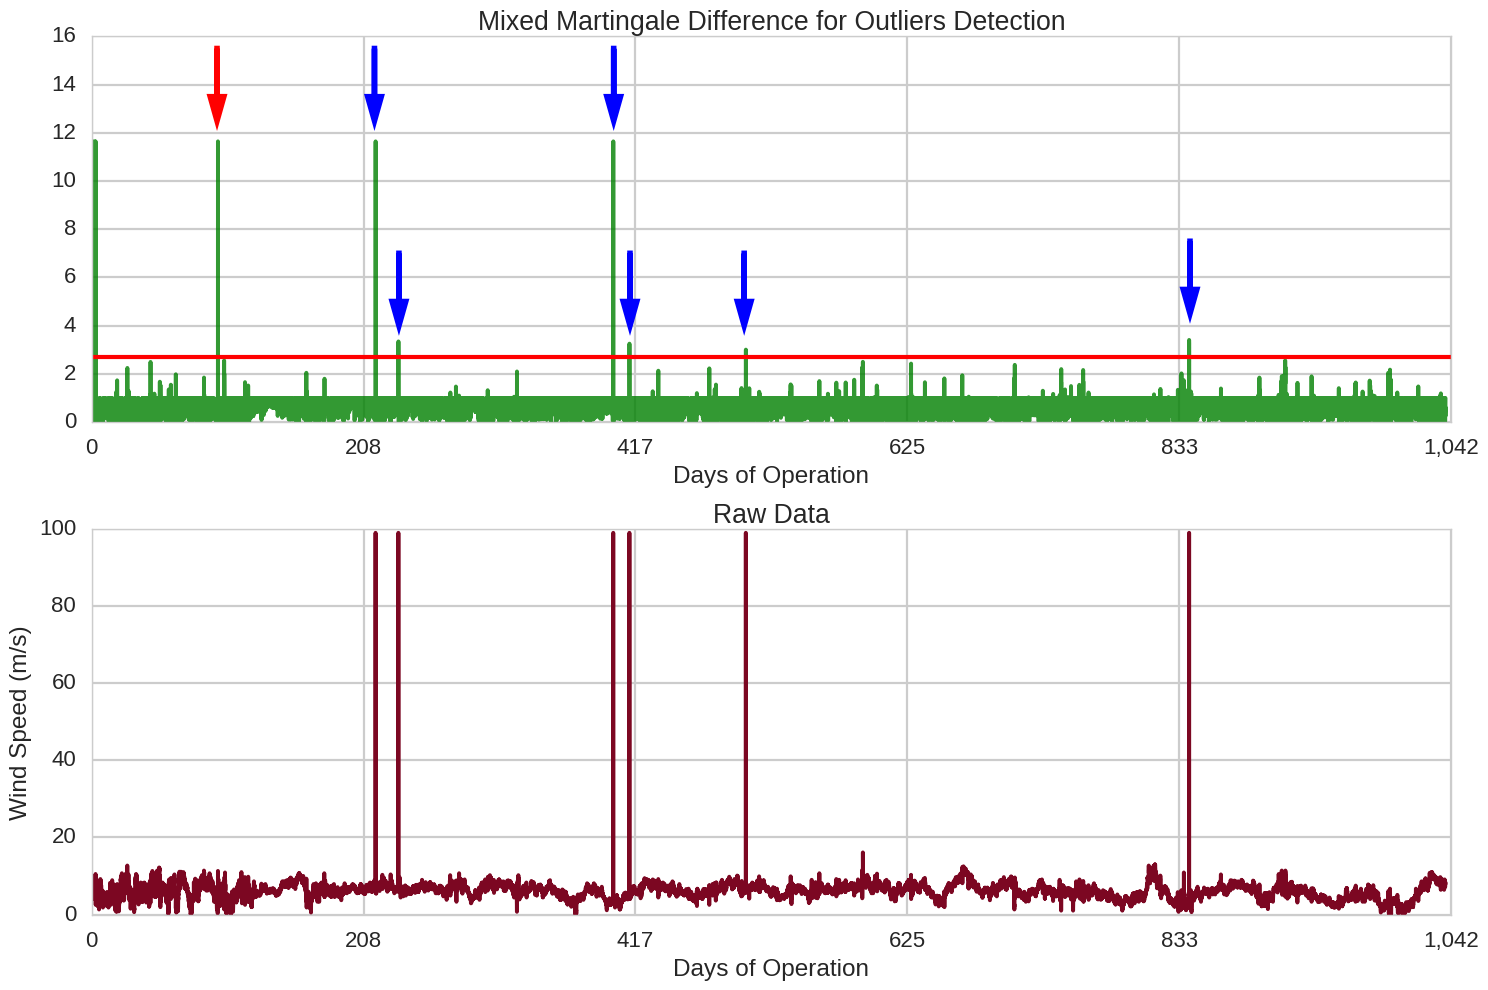

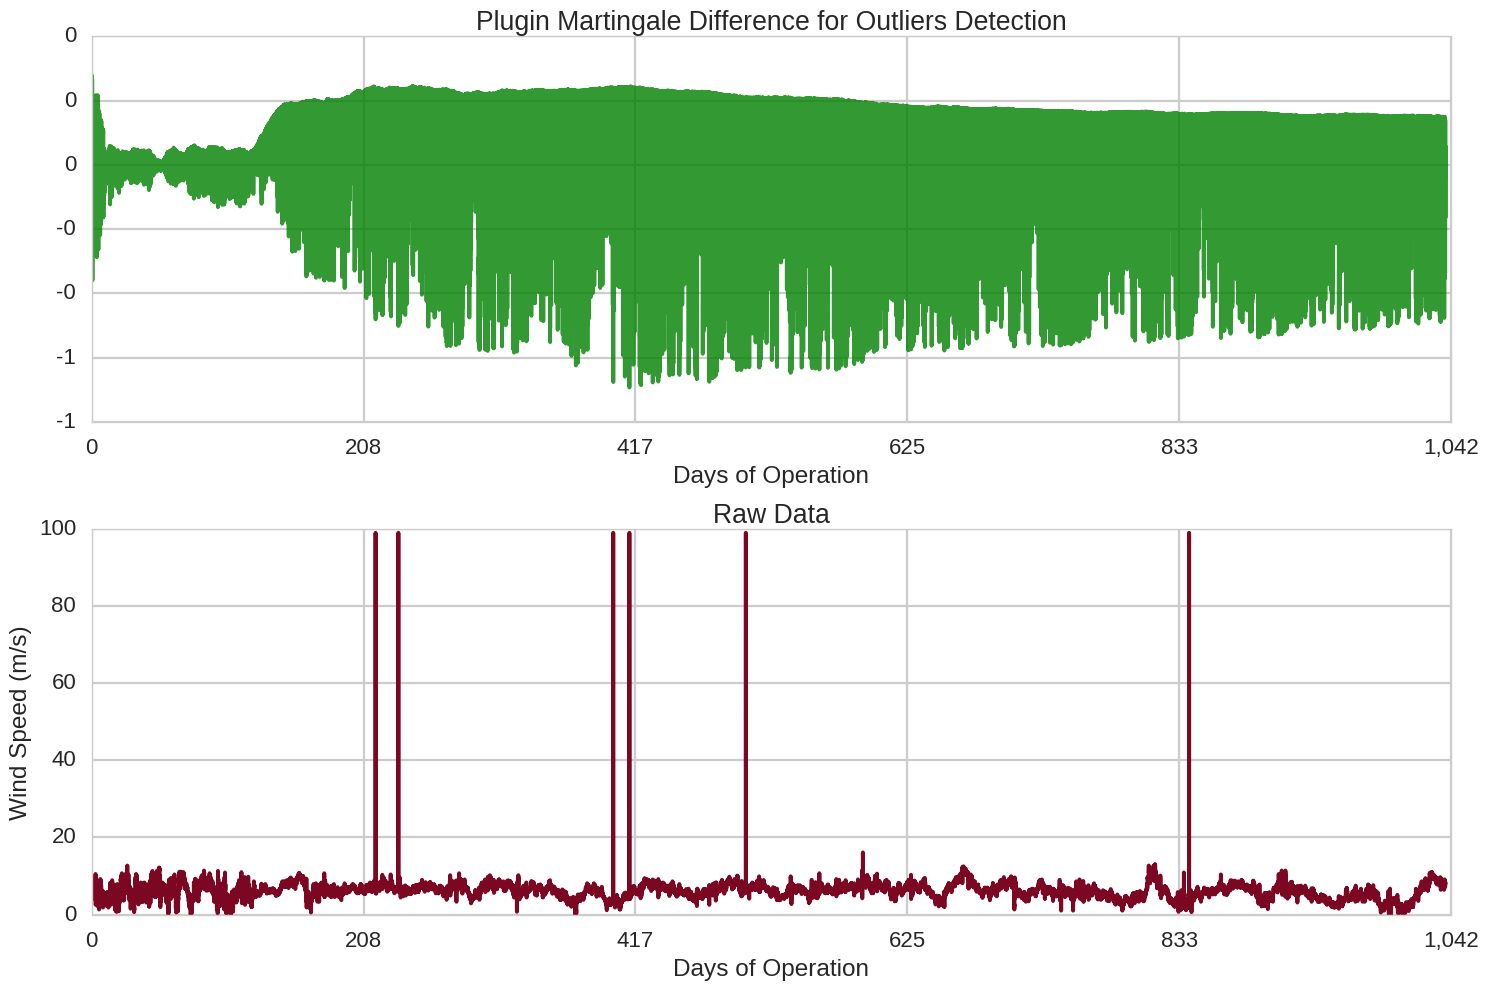

In [131]:
# Visualize change detection
# --------------------------

# Fixed Epsilon
fig = plt.figure(figsize = (15,10))

ax1 = fig.add_subplot(211)
ax1.plot(diff1_pwr , alpha = 0.8, color='g')
ax1.set_title('Fixed Epsilon Difference for Outliers Detection')
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')
ax1.set_ylabel('')
ax1.set_ylim([0,8])
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
ax1.axhline(y=4.4, linewidth=3, color='r')
ax1.arrow( 96*24, 6.5, 0, -1, fc="r", ec="r", head_width=250, head_length=0.5, linewidth=4)
ax1.arrow( 5200, 7.25, 0, -1, fc="b", ec="b", head_width=250, head_length=0.5, linewidth=4)
ax1.arrow( 5650, 7, 0, -1, fc="b", ec="b", head_width=250, head_length=0.5, linewidth=4)
ax1.arrow( 9600, 8, 0, -1, fc="b", ec="b", head_width=250, head_length=0.5, linewidth=4)
ax1.arrow( 9900, 7, 0, -1, fc="b", ec="b", head_width=250, head_length=0.5, linewidth=4)
ax1.arrow( 12000, 7, 0, -1, fc="b", ec="b", head_width=250, head_length=0.5, linewidth=4)
ax1.arrow( 20200, 7.5, 0, -1, fc="b", ec="b", head_width=250, head_length=0.5, linewidth=4)

ax2 = fig.add_subplot(212)
ax2.plot(out_test)
ax2.set_title('Raw Data')
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax2.set_xlabel('Days of Operation')
ax2.set_ylabel('Wind Speed (m/s)')
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
plt.tight_layout()
plt.show()

# Mix
fig = plt.figure(figsize = (15,10))

ax1 = fig.add_subplot(211)
ax1.plot(diff2_pwr , alpha = 0.8 , color='g' )
ax1.set_title('Mixed Martingale Difference for Outliers Detection')
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')
ax1.set_ylabel('')
ax1.set_ylim([0,16])
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
ax1.axhline(y=2.7, linewidth=3, color='r')
ax1.arrow( 96*24, 15.5, 0, -2, fc="r", ec="r", head_width=250, head_length=1, linewidth=4)
ax1.arrow( 5200, 15.5, 0, -2, fc="b", ec="b", head_width=250, head_length=1, linewidth=4)
ax1.arrow( 5650, 7, 0, -2, fc="b", ec="b", head_width=250, head_length=1, linewidth=4)
ax1.arrow( 9600, 15.5, 0, -2, fc="b", ec="b", head_width=250, head_length=1, linewidth=4)
ax1.arrow( 9900, 7, 0, -2, fc="b", ec="b", head_width=250, head_length=1, linewidth=4)
ax1.arrow( 12000, 7, 0, -2, fc="b", ec="b", head_width=250, head_length=1, linewidth=4)
ax1.arrow( 20200, 7.5, 0, -2, fc="b", ec="b", head_width=250, head_length=1, linewidth=4)


ax2 = fig.add_subplot(212)
ax2.plot(out_test)
ax2.set_title('Raw Data')
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax2.set_xlabel('Days of Operation')
ax2.set_ylabel('Wind Speed (m/s)')
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

plt.tight_layout()
plt.show()

# Plugin Martingale
fig = plt.figure(figsize = (15,10))

ax1 = fig.add_subplot(211)
ax1.plot(diff3_pwr , alpha = 0.8 , color='g' )
ax1.set_title('Plugin Martingale Difference for Outliers Detection')
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')
ax1.set_ylabel('')
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


ax2 = fig.add_subplot(212)
ax2.plot(out_test)
ax2.set_title('Raw Data')
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax2.set_xlabel('Days of Operation')
ax2.set_ylabel('Wind Speed (m/s)')
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
plt.tight_layout()
plt.show()

## 6.0- floor anomaly detection


In [28]:
# Application and Visualization
# -----------------------------

# Fixed Epsilon 
p_mar1_pwr_f , diff1_pwr_f = power_martingale(floor_train, floor_test, 0.9 , 1)

# Mixed Epsilon
p_mar2_pwr_f, diff2_pwr_f = power_martingale_mix(floor_train , floor_test , resolution, 1)

# Plugin Martingale
p_mar3_pwr_f, diff3_pwr_f = plugin_martingale(floor_train , floor_test, 1)

##

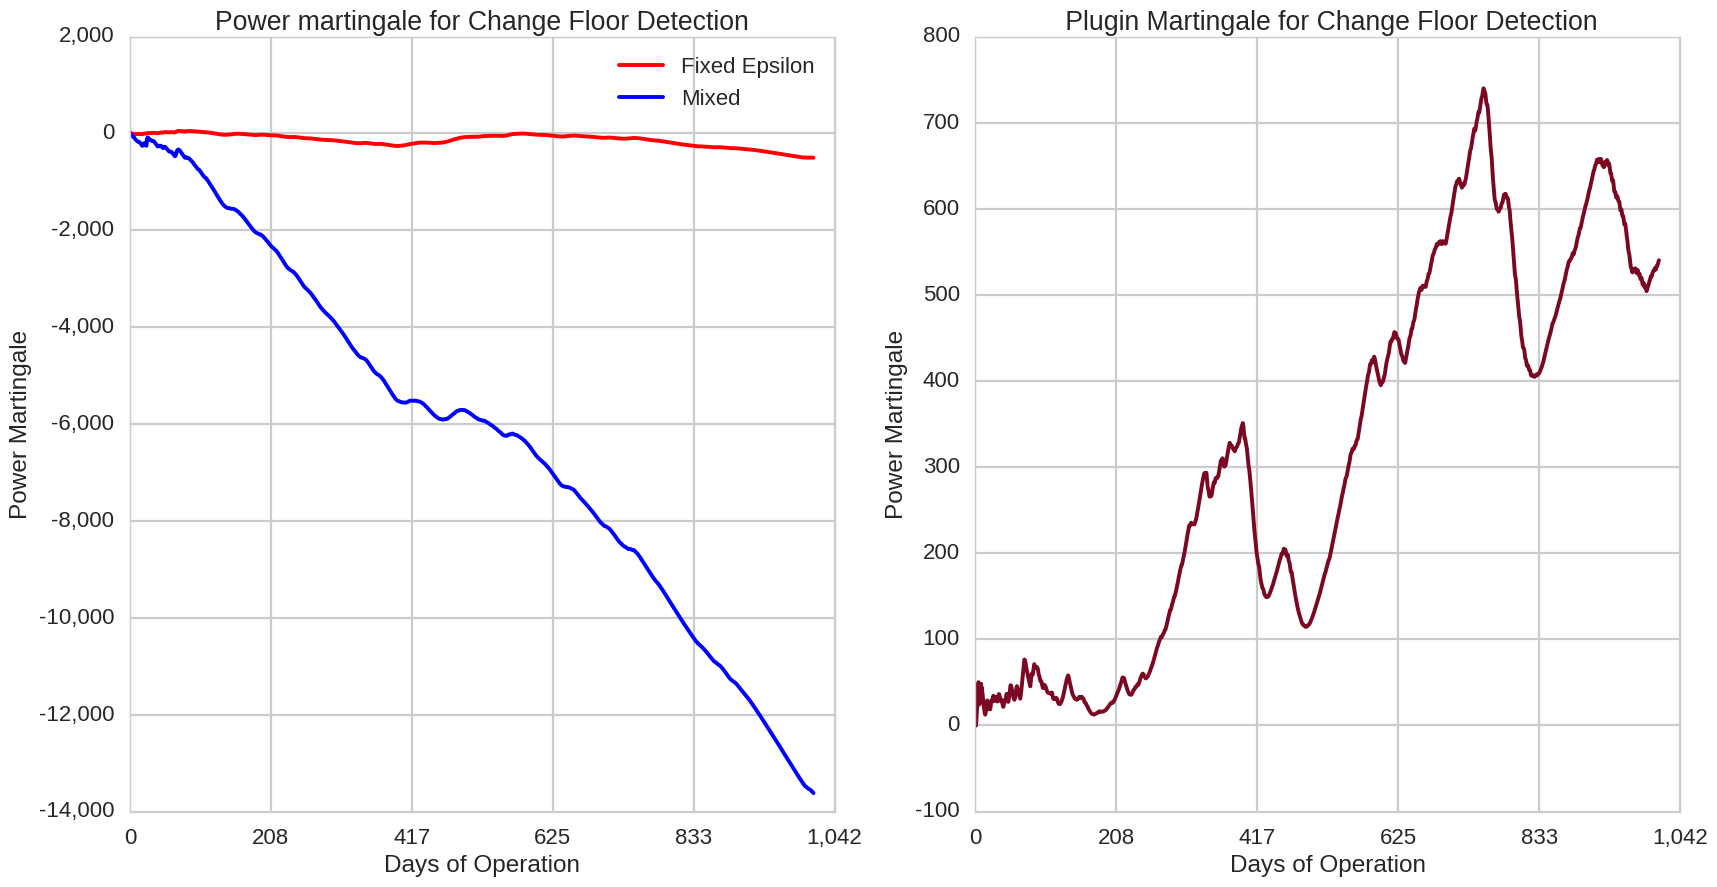

In [27]:
# Visualization of Power Martingale
# ---------------------------------

# plot initialization
fig = plt.figure(figsize = (20,10))

# plot fixed epsilon
ax1 = fig.add_subplot(1,2,1)
ax1.plot(p_mar1_pwr_f , 'r' , label = 'Fixed Epsilon')
ax1.plot(p_mar2_pwr_f , 'b' , label = 'Mixed')
ax1.set_title('Power martingale for Change Floor Detection')
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')
ax1.set_ylabel('Power Martingale')
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
ax1.legend()

# plot Plugin
ax2 = fig.add_subplot(1,2,2)
ax2.plot(p_mar3_pwr_f)
ax2.set_title(' Plugin Martingale for Change Floor Detection')
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax2.set_xlabel('Days of Operation')
ax2.set_ylabel('Power Martingale')
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

plt.show()

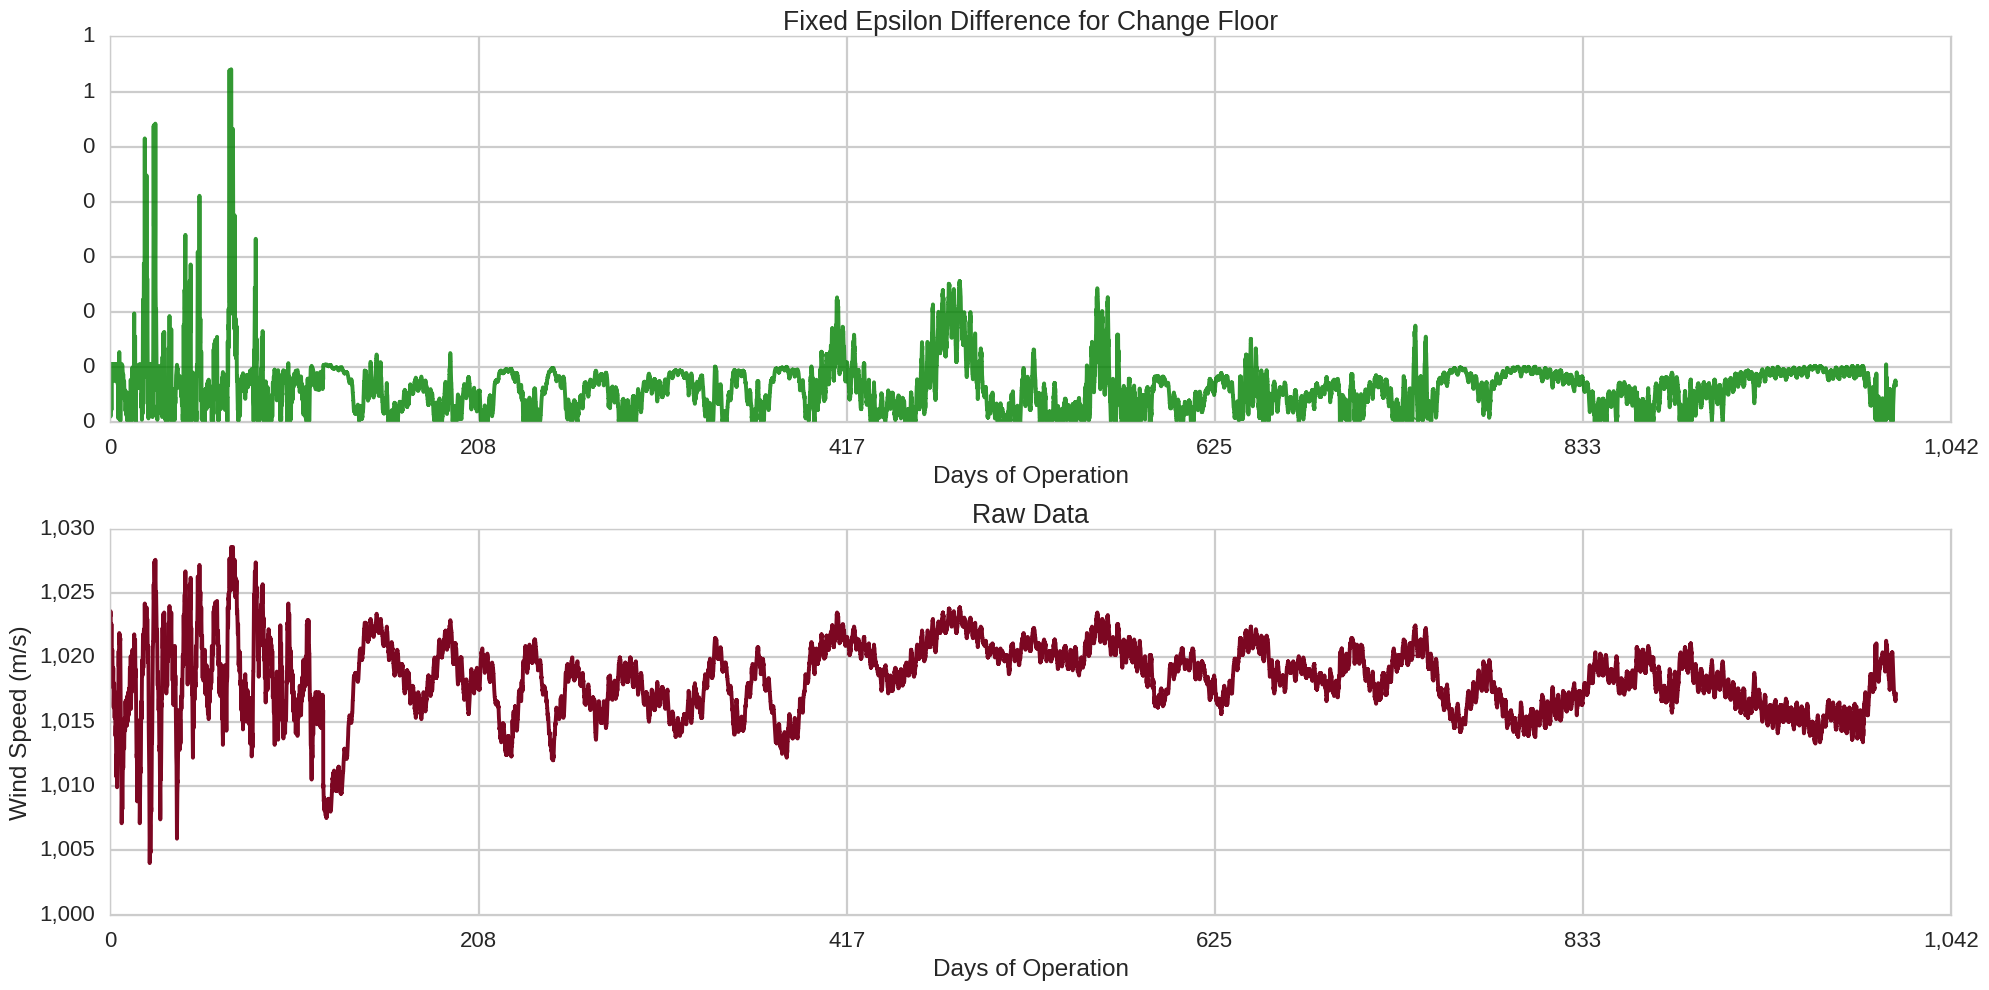

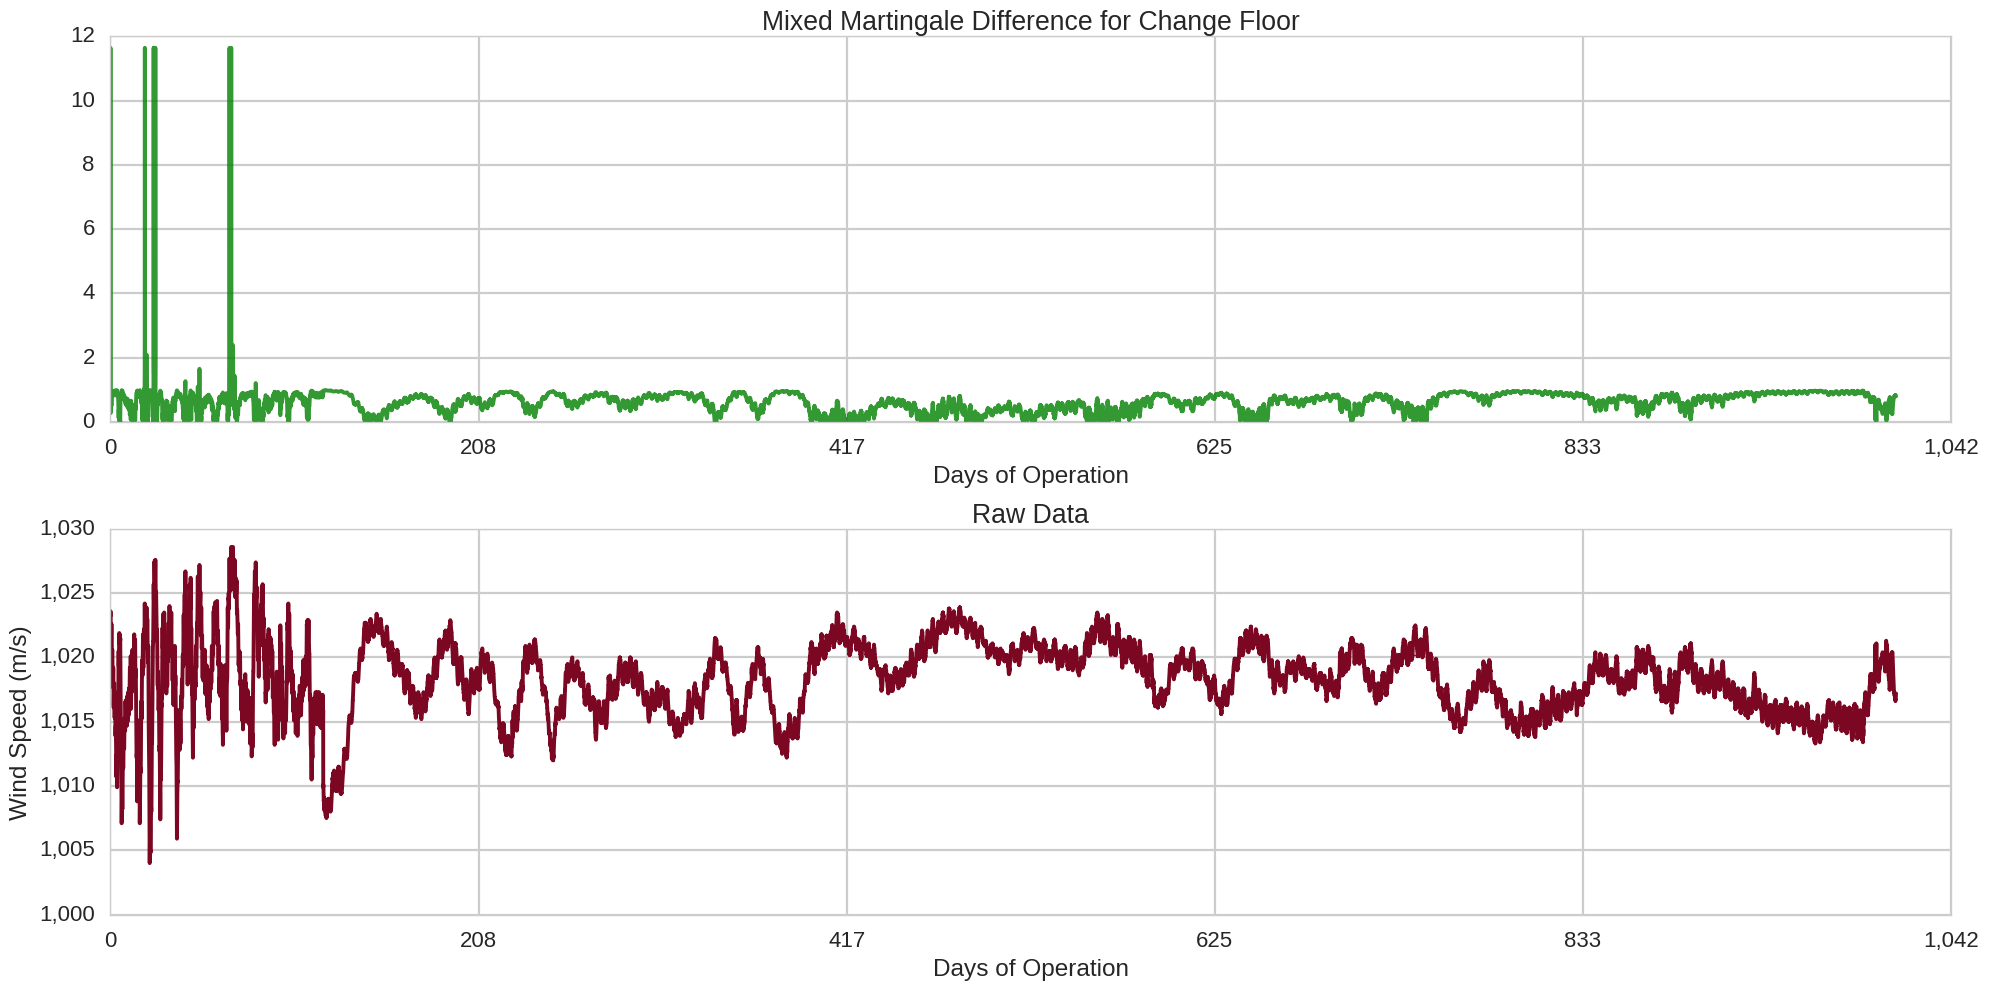

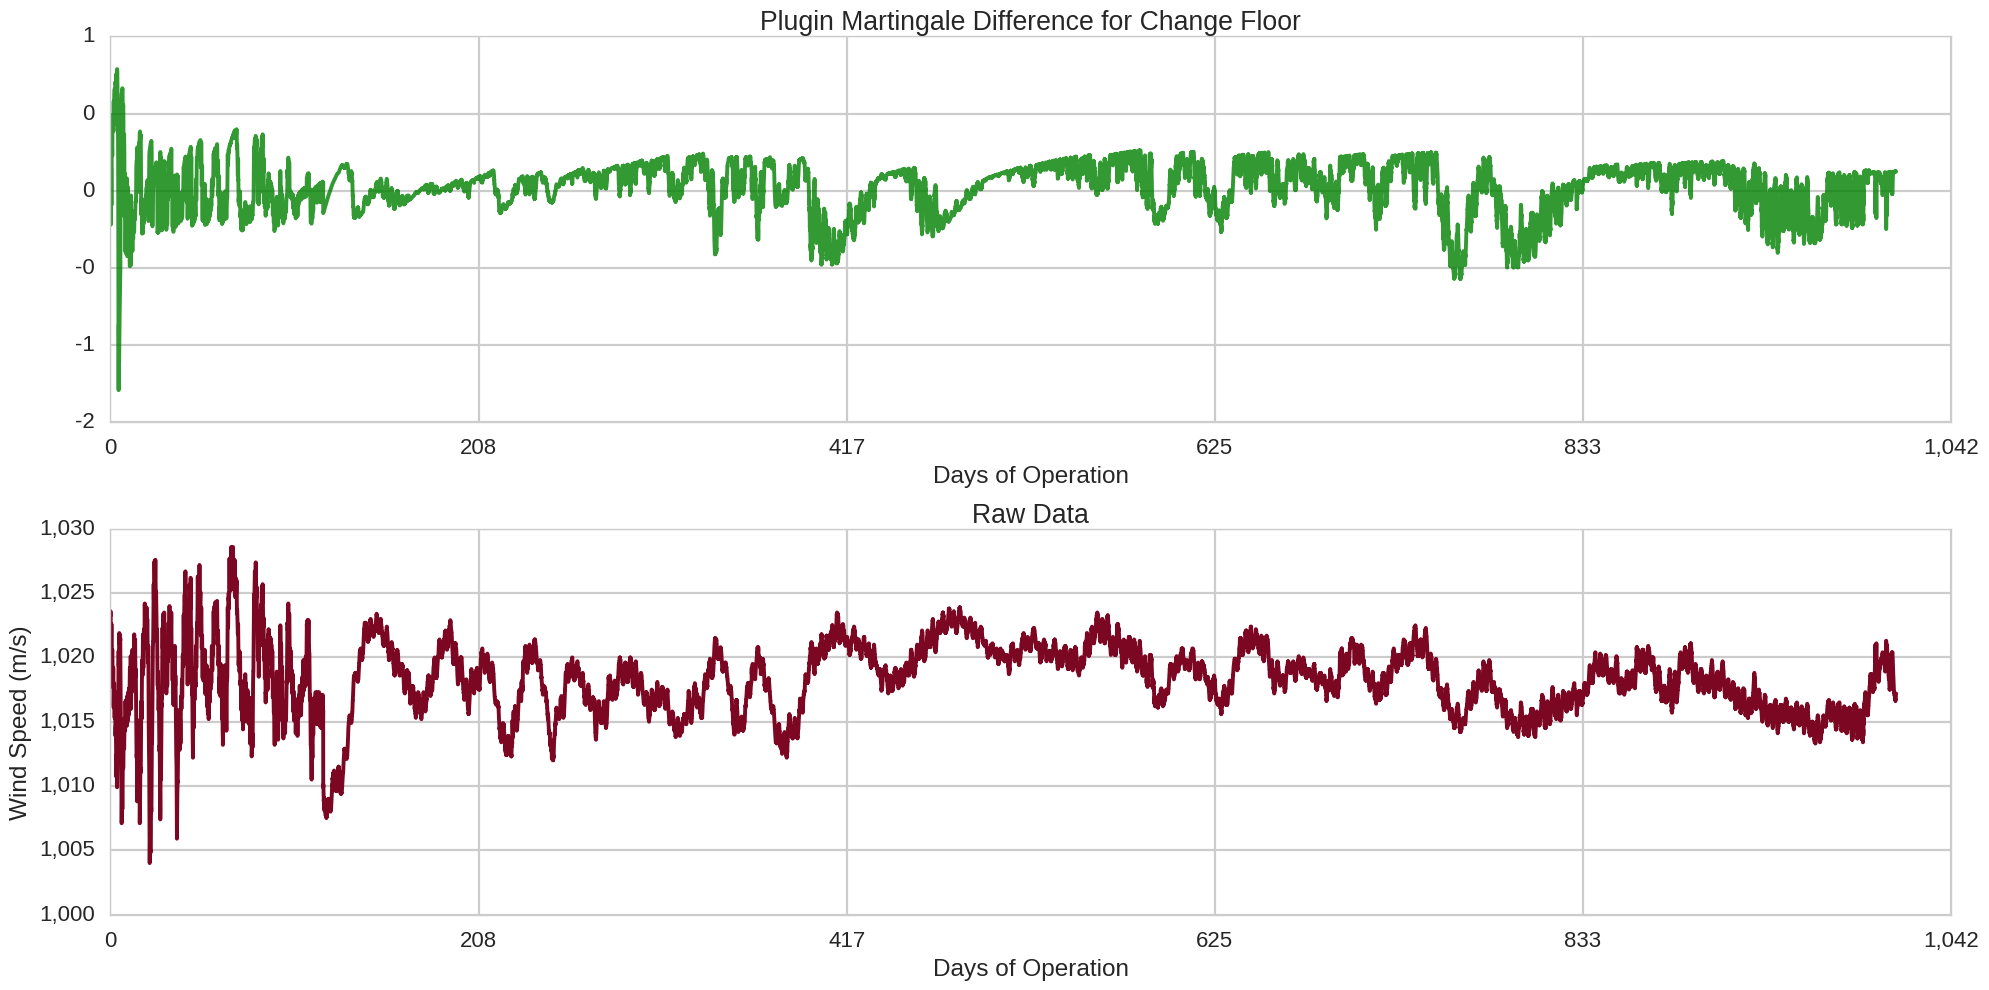

In [28]:
# Visualize change detection
# --------------------------

# Fixed Epsilon
fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(211)
ax1.plot(diff1_pwr_f , alpha = 0.8, color='g')
ax1.set_title('Fixed Epsilon Difference for Change Floor')
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')
ax1.set_ylabel('')
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


ax2 = fig.add_subplot(212)
ax2.plot(floor_test)
ax2.set_title('Raw Data')
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax2.set_xlabel('Days of Operation')
ax2.set_ylabel('Wind Speed (m/s)')
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
plt.tight_layout()
plt.show()

# Mix
fig = plt.figure(figsize = (20, 10))

ax1 = fig.add_subplot(211)
ax1.plot(diff2_pwr_f , alpha = 0.8 , color='g' )
ax1.set_title('Mixed Martingale Difference for Change Floor')
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')
ax1.set_ylabel('')
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


ax2 = fig.add_subplot(212)
ax2.plot(floor_test)
ax2.set_title('Raw Data')
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax2.set_xlabel('Days of Operation')
ax2.set_ylabel('Wind Speed (m/s)')
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
plt.tight_layout()
plt.show()

# Plugin Martingale
fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(211)
ax1.plot(diff3_pwr_f , alpha = 0.8 , color='g' )
ax1.set_title('Plugin Martingale Difference for Change Floor')
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')
ax1.set_ylabel('')
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


ax2 = fig.add_subplot(212)
ax2.plot(floor_test)
ax2.set_title('Raw Data')
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax2.set_xlabel('Days of Operation')
ax2.set_ylabel('Wind Speed (m/s)')
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

plt.tight_layout()
plt.show()

---